# Feature Selection with Downsampling

## Data

In [1]:
# loading necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('thl_recoded.csv')
data.head()

,kannabis,alcohol_use,nuuska,cigarette,e_cigarette,prob_country,prob_resident,risk_of_use,risk_of_try,cannabis_access,...,household_2.0,household_3.0,education_2.0,education_3.0,education_4.0,violence_treat_2.0,violence_treat_3.0,drug_punishment_2.0,drug_punishment_3.0,drug_punishment_4.0
0,0.0,3.0,1.0,1.0,1.0,3.0,2.0,24.0,13.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,3.0,2.0,23.0,17.0,3.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,5.0,1.0,2.0,1.0,4.0,3.0,24.0,18.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,7.0,2.0,2.0,1.0,3.0,2.0,22.0,12.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,5.0,1.0,1.0,1.0,3.0,2.0,24.0,16.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [3]:
 # Kannabis use
data['kannabis'].value_counts(normalize= True)

0.0    0.914525
1.0    0.085475
Name: kannabis, dtype: float64

In [4]:
from sklearn.model_selection import train_test_split

X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

## Model

In [5]:
w_class0 = np.where(y == 0)[0]
w_class1 = np.where(y == 1)[0]

n_class0 = len(w_class0) 
n_class1 = len(w_class1)
 

print("n_class0: ", n_class0)
print("n_class1: ", n_class1)

n_class0:  2953
n_class1:  276


In [6]:
w_class1_downsampled = np.random.choice(w_class1, size=n_class0)

print()
print(np.hstack((y[w_class0], y[w_class1_downsampled])))


[0. 0. 0. ... 1. 1. 1.]


In [7]:
no_cannabis = data[data["kannabis"] == 0]
yes_cannabis  = data[data["kannabis"] == 1]
print(no_cannabis.shape)
print(yes_cannabis.shape)

(2953, 49)
(276, 49)


In [8]:
from sklearn.utils import resample
cannabis_downsample = resample(no_cannabis,
             replace=True,
             n_samples=len(yes_cannabis),
             random_state=42)

print(cannabis_downsample.shape)

(276, 49)


0.0    276
1.0    276
Name: kannabis, dtype: int64


<AxesSubplot:ylabel='Type'>

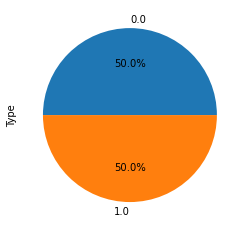

In [9]:
data_downsampled = pd.concat([cannabis_downsample, yes_cannabis])
print(data_downsampled["kannabis"].value_counts())

data_downsampled.groupby('kannabis').size().plot(kind='pie',
                                       y = "kannabis",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [10]:
from sklearn.model_selection import train_test_split

X, y = data_downsampled.iloc[:, 1:].values, data_downsampled.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [11]:
print('Dimension of X train: ', X_train.shape)
print('Target 1: ', np.count_nonzero(y_train == 1))
print('Target 0: ', np.count_nonzero(y_train == 0))



print('\n ---------------------\n')
print('Dimension of X test :', X_test.shape)
print('Target 1: ', np.count_nonzero(y_test == 1))
print('Target 0: ', np.count_nonzero(y_test == 0))

Dimension of X train:  (386, 48)
Target 1:  193
Target 0:  193

 ---------------------

Dimension of X test : (166, 48)
Target 1:  83
Target 0:  83


## 1. Gradient Boosting Classifier

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE


from sklearn.ensemble import GradientBoostingClassifier
rfecv = RFECV(estimator=GradientBoostingClassifier())
model = GradientBoostingClassifier()

In [13]:
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=36851234)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.8446783895127148

In [14]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=GradientBoostingClassifier())),
                ('Model', GradientBoostingClassifier())])

In [15]:
print('Optimal number of features : %d' % rfecv.n_features_)

Optimal number of features : 20


In [16]:
rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv.support_rfecv_df.head(15)

,Rank
alcohol_use,1
drug_offer_1,1
alcohol_hp_1,1
"age_bins_(24, 34]",1
single_1,1
non_medical_1,1
sport,1
current_health,1
drug_user_friend_1,1
intoxicant_access,1


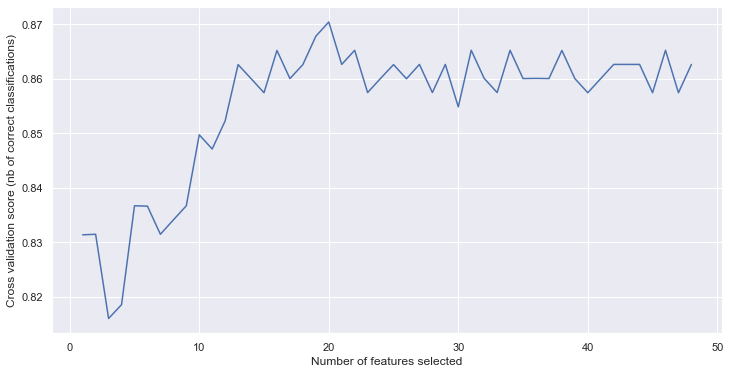

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

<AxesSubplot:>

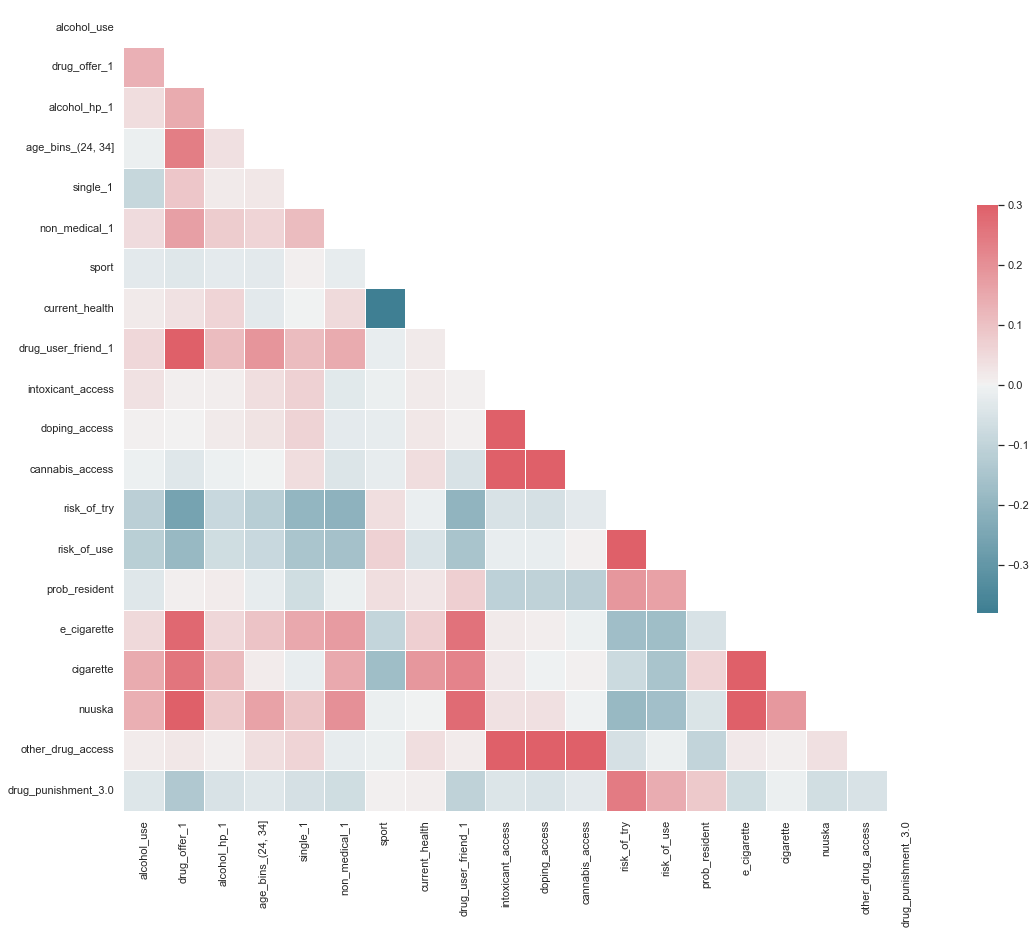

In [18]:
dt_columns = rfecv.support_rfecv_df [rfecv.support_rfecv_df ['Rank']==1].reset_index()
dt_columns = list(np.array(dt_columns['index']))

# New Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = data[dt_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, )
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

Accuracy: 0.8614
Precision: 0.8615
Recall: 0.8614
F1 Score: 0.8614
Cohen Kappa Score: 0.7229
Matthews Corrcoef: 0.7229
roc_auc_score: 0.8614457831325301
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.86      0.86        84
         1.0       0.86      0.87      0.86        82

    accuracy                           0.86       166
   macro avg       0.86      0.86      0.86       166
weighted avg       0.86      0.86      0.86       166

Confusion Matrix:
 [[72 11]
 [12 71]]


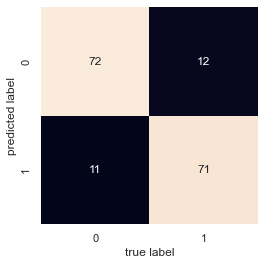

In [19]:
y_pred = pipeline.predict(X_test)
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

## 2. Random Forest 

In [20]:
from sklearn.ensemble import RandomForestClassifier

rfecv_rfauto= RFECV(estimator=RandomForestClassifier())

model_rfauto = RandomForestClassifier(n_estimators=100, random_state=92116)

In [21]:
pipeline_rfauto = Pipeline([('Feature Selection', rfecv_rfauto), ('Model', model_rfauto)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=92116)
n_scores = cross_val_score(pipeline_rfauto, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.8724608724608726

In [22]:
pipeline_rfauto.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=RandomForestClassifier())),
                ('Model', RandomForestClassifier(random_state=92116))])

In [23]:
print('Optimal number of features : %d' % rfecv_rfauto.n_features_)

Optimal number of features : 31


<AxesSubplot:>

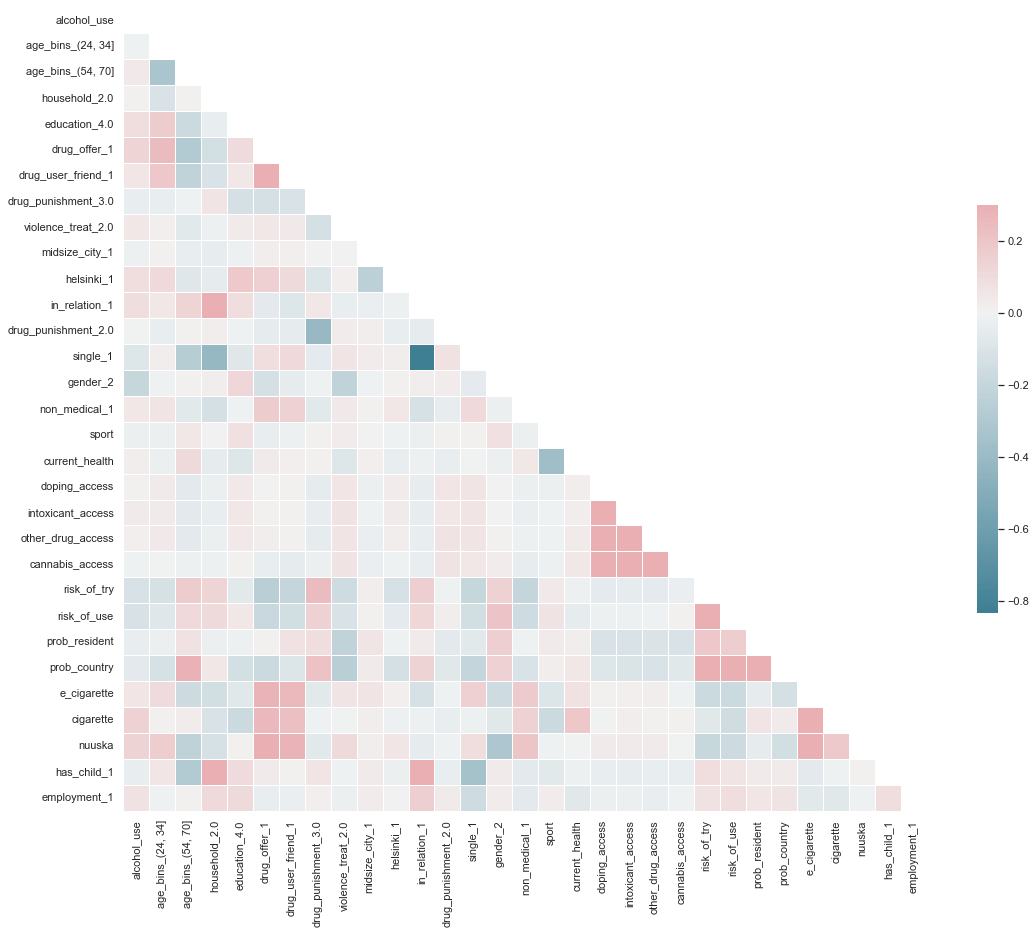

In [24]:
rfecv_rfauto.support_rfecv_df = pd.DataFrame(rfecv_rfauto.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)

dt_columns = rfecv_rfauto.support_rfecv_df [rfecv_rfauto.support_rfecv_df ['Rank']==1].reset_index()
dt_columns = list(np.array(dt_columns['index']))

# New Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = data[dt_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, )
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Accuracy: 0.8855
Precision: 0.886
Recall: 0.8855
F1 Score: 0.8855
Cohen Kappa Score: 0.7711
Matthews Corrcoef: 0.7716
roc_auc_score: 0.8855421686746989
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.87      0.89        86
         1.0       0.87      0.90      0.88        80

    accuracy                           0.89       166
   macro avg       0.89      0.89      0.89       166
weighted avg       0.89      0.89      0.89       166

Confusion Matrix:
 [[75  8]
 [11 72]]


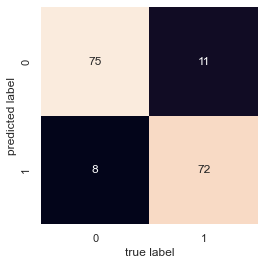

In [25]:
y_pred = pipeline_rfauto.predict(X_test)
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

In [26]:
dt_columns

['alcohol_use',
 'age_bins_(24, 34]',
 'age_bins_(54, 70]',
 'household_2.0',
 'education_4.0',
 'drug_offer_1',
 'drug_user_friend_1',
 'drug_punishment_3.0',
 'violence_treat_2.0',
 'midsize_city_1',
 'helsinki_1',
 'in_relation_1',
 'drug_punishment_2.0',
 'single_1',
 'gender_2',
 'non_medical_1',
 'sport',
 'current_health',
 'doping_access',
 'intoxicant_access',
 'other_drug_access',
 'cannabis_access',
 'risk_of_try',
 'risk_of_use',
 'prob_resident',
 'prob_country',
 'e_cigarette',
 'cigarette',
 'nuuska',
 'has_child_1',
 'employment_1']

# Summary

The model improves compared to upsampling method but still behind the expectations. In the next step, I will use hybrit methods.